# Project Overview

## Exploring Email Categorization Using the Enron Dataset

The primary goal of this project is to explore the problem of categorizing work emails into meaningful categories. We aim to understand the challenges, experiment with different approaches, and gain insights into the structure and content of emails in the Enron dataset.

We are using the Enron dataset, a well-known collection of emails from the Enron Corporation, which provides a rich source of real-world email data for analysis. Because of the nature of the dataset—being human-made and inherently messy—we anticipate that the data may not be separable, even after extensive cleaning and processing. This reflects the real-world challenges of working with natural language data, where ambiguity, noise, and overlapping categories are common.

The emails in the dataset have been organized into folders by the company workers. Some of these folders may have meaningful names that could help us semantically separate the emails and explore the dataset, and some of the folders could be too generic and lack special meaning.

Despite these challenges, we plan to use the folder names as labels for the emails. This approach allows us to explore the dataset and the problem of email categorization. We anticipate that emails placed in specific folders hold semantic significance in their body and subject, which can be learned by our models. For example, emails categorized under a folder named "budget" are likely to contain financial terms or discussions, while those in a folder named "meetings" may include scheduling-related content.

## https://www.kaggle.com/datasets/wcukierski/enron-email-dataset

## you can download the emails.csv dataset in this link

## Downloading dependencies

In [1]:
!pip install sentence_transformers

In [2]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 7.8 MB/s eta 0:00:00


In [3]:
!pip install scikit-learn-intelex

   ---------------------------------------- 0.0/3.3 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.3 MB ? eta -:--:--
   ---------------------------------------- 3.3/3.3 MB 13.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/68.5 MB ? eta -:--:--
   -------- ------------------------------- 14.4/68.5 MB 69.7 MB/s eta 0:00:01
   ----------------- ---------------------- 29.9/68.5 MB 70.2 MB/s eta 0:00:01
   --------------------------- ------------ 46.4/68.5 MB 72.1 MB/s eta 0:00:01
   ------------------------------------ --- 62.7/68.5 MB 72.6 MB/s eta 0:00:01
   ---------------------------------------- 68.5/68.5 MB 64.3 MB/s eta 0:00:00


In [4]:
!pip install mglearn
!pip install wordcloud

## Importing libraries

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
import sklearn
import email
import re
import plotly.express as px
from difflib import get_close_matches
import mglearn
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import plotly.figure_factory as ff
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import ast
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearnex import patch_sklearn
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
patch_sklearn()
nltk.download('punkt_tab')
nltk.download("stopwords")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Shoham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shoham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## Preparing the data

### Loading the data

## update the folders path according to your preferences emails.csv

In [6]:
datastore_path = "../db/"
emails = pd.read_csv(os.path.join(datastore_path, "emails.csv"))

### Extracting features

Here we also created 2 more features which are Number of Recipients and Content-Length(the email body length)

In [7]:
# Function to parse an email and extract required features
def parse_email(raw_email):
    msg = email.message_from_string(raw_email)
    
    date = msg['Date']
    sender = msg['From']
    recipients = msg['To']
    subject = msg['Subject'] if msg['Subject'] else ""
    
    # Extract body
    body = ""
    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == "text/plain":
                body += part.get_payload(decode=True).decode(errors='ignore')
    else:
        body = msg.get_payload(decode=True).decode(errors='ignore')
    
    content_length = len(body)
    num_recipients = len(recipients.split(",")) if recipients else 0
    
    x_folder = msg['X-Folder'] if 'X-Folder' in msg else "Unknown"
    x_folder = x_folder.split("\\")[-1].lower()  # Extract only the last folder name
    
    return pd.Series([x_folder, date, sender, recipients, subject, body, content_length, num_recipients])

In [8]:
# Apply function to extract headers
emails[['X-Folder', 'Date', 'From', 'To', 'Subject', 'Body', 'Content-Length', 'Number of Recipients']] = emails['message'].apply(parse_email)
emails.head()

file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message    X-Folder  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...  'sent mail   
1  Message-ID: <15464986.1075855378456.JavaMail.e...  'sent mail   
2  Message-ID: <24216240.1075855687451.JavaMail.e...  'sent mail   
3  Message-ID: <13505866.1075863688222.JavaMail.e...  'sent mail   
4  Message-ID: <30922949.1075863688243.JavaMail.e...  'sent mail   

                                    Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   

                        To    Subject  \
0     tim.belden@enron.com              
1  john.lavorato@enron.com        Re:   
2   leah.arsdall@enron.com   Re: test   
3    randall.gay@enron.com              
4     greg.piper@enron.com  Re: Hello   

                                                Body  Content-Length  \
0                          Here is our forecast\n\n               23   
1  Traveling to have a business meeting takes the...             786   
2                     test successful.  way to go!!!              30   
3  Randy,\n\n Can you send me a schedule of the s...             187   
4                Let's shoot for Tuesday at 11:45.                35   

   Number of Recipients  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [9]:
# Show full message content
pd.set_option('display.max_colwidth', None)  # Allow full text display
print(emails.loc[0]['message'])


Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [10]:
#drop columns that are not needed anymore
columns_to_drop = ['file', 'Date']
emails = emails.drop(columns_to_drop, axis=1)

In [11]:
emails.columns

Index(['message', 'X-Folder', 'From', 'To', 'Subject', 'Body',
       'Content-Length', 'Number of Recipients'],
      dtype='object')

In [12]:
# Count emails with 1 recipient vs more than 1 recipient
one_recipient_count = (emails['Number of Recipients'] == 1).sum()
multiple_recipients_count = (emails['Number of Recipients'] > 1).sum()

print("Number of emails with 1 recipient:", one_recipient_count)
print("Number of emails with more than 1 recipient:", multiple_recipients_count)

Number of emails with 1 recipient: 354298
Number of emails with more than 1 recipient: 141256


## Visualising and cleaning the data

In [13]:
print(emails["X-Folder"].sample(7))

322248                  sent
497098         all documents
311619    discussion threads
435473         all documents
109252             logistics
379526    discussion threads
3800              'sent mail
Name: X-Folder, dtype: object


In [ ]:
# Visualize folders by size using Plotly
folder_counts = emails['X-Folder'].value_counts().reset_index()
folder_counts.columns = ['X-Folder', 'Count']

fig = px.bar(folder_counts[:40], x='Count', y='X-Folder', orientation='h', title='Top 40 Email Folders by Count')
fig.show()


### As shown in the visualization of the top 40 email folders by count, folders like "inbox," "calendar," and "junk file" are among the most common. These generic folders not only lack meaningful distinctions but also create an imbalance in the dataset, as they contain a disproportionately large number of emails compared to more specific folders.

In [ ]:
# Remove generic folders
generic_folders = {"inbox", "sent", "deleted items", "drafts", "all documents", "discussion threads", "'sent mail", "discussion threads", "sent items", 
                  "untitled", "notes inbox", "calendar"}
emails = emails[~emails['X-Folder'].isin(generic_folders)]

In [ ]:
print(emails['X-Folder'].value_counts()) 

In [ ]:
print(len(emails))

We can see that the main portion of the data was reduced because it belonged to generic folders (e.g., "inbox," "calendar," "junk file") that we are not interested in. These folders not only lack meaningful distinctions but would also contribute to the imbalance of the dataset if included. Furthermore, after performing some preliminary background analysis, we discovered that most folders contain very few emails, making them unsuitable for training a robust classification model.

To address this, we targeted folders with a significant number of emails and related names, combining them into 9 categories that we deemed fitting as labels for the emails. These categories were chosen based on their semantic relevance and the volume of emails they contained, ensuring a more balanced and meaningful dataset for our exploration of email categorization.

In [ ]:
# Merge specified similar folder names
merge_folders = {
    "personnel": "personal",
    "personalfolder": "personal",
    "personal mail": "personal",
    "personal stuff": "personal",
    "personnal": "personal",
    "human resources": "hr",
    "netco hr": "hr",
    "resumes": "hr",
    "interviews": "hr",
    "recruiting": "hr",
    "meetings": "meetings and scheduling",
    "conferences": "meetings and scheduling",
    "schedule crawler": "meetings and scheduling",
    "scheduling": "meetings and scheduling",
    "tufco": "operations and logistics",
    "industrial": "operations and logistics",
    "deal discrepancies": "operations and logistics",
    "logistics": "operations and logistics",
    "retail": "operations and logistics",
    "mckinsey project": "projects",
    "project stanley": "projects",
    "corporate": "corporate and legal",
    "regulatory": "corporate and legal",
    "netco legal": "corporate and legal",
    "federal legislation": "corporate and legal",
    "federal legis.": "corporate and legal",
    "legal": "corporate and legal",
    "corp info_announcements": "corporate and legal",
    "legal agreements": "corporate and legal",
    "corporate comm": "corporate and legal",
    "archives": "archive and miscellaneous",
    "junk": "archive and miscellaneous",
    "e-mail bin": "archive and miscellaneous",
    "old inbox": "archive and miscellaneous",
    "misc": "archive and miscellaneous",
    "miscellaneous": "archive and miscellaneous",
    "misc tw": "archive and miscellaneous",
    "misc.": "archive and miscellaneous",
    "online trading": "finance",
    "market": "finance",
    "mrkt info": "finance",
    "credit derivatives": "finance",
    "tradecounts": "finance",
    "trading info": "finance",
    "2002 budget": "finance",
    "budget": "finance",
    "broker quotes": "finance",
    "kpmg": "finance",
    "palo alto": "it",
    "internet": "it",
    "internet sites": "it"
    
    
}
emails['X-Folder'] = emails['X-Folder'].replace(merge_folders)


In [ ]:
# List of X-Folder categories you want to count
folders_to_count = [
    "personal", "hr", "meetings and scheduling", "operations and logistics", 
    "projects", "corporate and legal", "archive and miscellaneous", "it", "finance"
]

# Count occurrences of each folder in the 'X-Folder' column
folder_counts = emails['X-Folder'].value_counts()

# Filter counts for the specific folders
filtered_counts = folder_counts[folder_counts.index.isin(folders_to_count)]

# Display the result
print(filtered_counts)

In [ ]:
# Filter the DataFrame
filtered_emails = emails[emails['X-Folder'].isin(folders_to_count)]

# Save to a new CSV file
filtered_emails.to_csv(os.path.join(datastore_path, "filtered_emails.csv"), index=False)

print("Filtered CSV saved as 'filtered_emails.csv'")

In [ ]:
filtered_emails = pd.read_csv(os.path.join(datastore_path, "filtered_emails.csv"))

In [ ]:
# Visualize folders by size using Plotly
folder_counts = filtered_emails['X-Folder'].value_counts().reset_index()
folder_counts.columns = ['X-Folder', 'Count']

fig = px.bar(folder_counts, x='Count', y='X-Folder', orientation='h', title='Email Folders by Count')
fig.show()

In [ ]:
# Convert folder names into a list of tokenized words
tokenized_folders = [word_tokenize(folder.lower()) for folder in filtered_emails['X-Folder'].unique()]

In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_folders, vector_size=300, window=5, min_count=1, workers=4)

In [ ]:
# Ensure word vector retrieval works correctly
def vector_rep(word):
    if word in word2vec_model.wv.key_to_index:
        return word2vec_model.wv[word]  # Correct shape: (300,)
    return np.zeros(shape=(300,))  # Match shape to (300,)

# Compute average vector for a phrase
def general_vector_rep(phrase):
    tokenized = word_tokenize(phrase)
    
    if len(tokenized) == 0:
        return np.zeros(shape=(300,))  # Match shape
    
    vectors = np.array([vector_rep(word) for word in tokenized])  # Vectorized
    
    return np.mean(vectors, axis=0)  # Average across words

# Create DataFrame of vector representations
def make_vector_rep_df(labels):
    vectors_dict = {label: general_vector_rep(label) for label in labels}  # Dictionary comprehension
    
    df = pd.DataFrame.from_dict(vectors_dict, orient='index')  # Create DataFrame
    
    # Replace any NaN rows with zeros
    df.fillna(0, inplace=True)

    return df 

In [ ]:
folder_embeddings = make_vector_rep_df(list(filtered_emails['X-Folder'].unique()))
folder_embeddings.to_csv(os.path.join(datastore_path, "folder_embeddings.csv"), index=False)
folder_embeddings.head()

In [ ]:

# Apply t-SNE to reduce 300D vectors to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_results = tsne.fit_transform(folder_embeddings)

# Convert into a DataFrame
tsne_df = pd.DataFrame(tsne_results, columns=["TSNE 1", "TSNE 2"])
tsne_df["Folder"] = folder_embeddings.index  

# Plot using Plotly Express
fig = px.scatter(tsne_df, x="TSNE 1", y="TSNE 2", text="Folder", title="t-SNE Projection of Folder Embeddings")
fig.update_traces(textposition="top center", marker=dict(size=10))
fig.show()



The folders appear to form distinct clusters, indicating that folders within the same cluster are semantically similar

Some clusters are close to each other (e.g., "Corporate and Legal" and "Finance"), suggesting potential overlap in their content or themes.

Folders that are far from the main clusters may represent unique or less common topics.

### Removing nan values from the emails

In [ ]:
# Count missing (NaN) subjects
empty_subject_count = filtered_emails['Subject'].isna().sum()

# Count empty strings
empty_string_subject_count = (filtered_emails['Subject'] == "").sum()

# Total empty subjects
total_empty_subjects = empty_subject_count + empty_string_subject_count

print(f"Total emails with empty subject: {total_empty_subjects}")


In [ ]:
# Count missing (NaN) subjects
empty_body_count = filtered_emails['Body'].isna().sum()

# Count empty strings
empty_string_body_count = (filtered_emails['Body'] == "").sum()

# Total empty subjects
total_empty_body = empty_body_count + empty_string_body_count

print(f"Total emails with empty Body: {total_empty_body}")


In [ ]:
filtered_emails = filtered_emails[filtered_emails['Subject'].notna() & (filtered_emails['Subject'] != "")]

# Reset index after removal (optional)
filtered_emails = filtered_emails.reset_index(drop=True)

print(f"Remaining emails after removing empty subjects: {len(filtered_emails)}")

In [ ]:
# Visualize folders again after the subject cleanup by size using Plotly.
folder_counts = filtered_emails['X-Folder'].value_counts().reset_index()
folder_counts.columns = ['X-Folder', 'Count']

fig = px.bar(folder_counts, x='Count', y='X-Folder', orientation='h', title='Email Folders by Count')
fig.show()

From the visualization of Email Folders by Count, we can see that the remaining emails are more evenly distributed across the labels after removing the generic folders. This redistribution has resulted in a more balanced dataset, which is now more suitable for analysis and modeling. The categories such as Projects, IT, Finance, Corporate and Legal, HR, Archive and Miscellaneous, Operations and Logistics, Personal, and Meetings and Scheduling each contain a reasonable number of emails, reducing the risk of class imbalance. This balanced distribution allows us to work with the data more effectively, ensuring that our models can learn from a representative sample of each category.

### Embeding the subjects and bodies using word2vec

#### tokenizing and cleaning the words

In [ ]:
# Load English stopwords
stop_words = set(stopwords.words("english"))

# ✅ Function to Clean & tokenize Email contents
def clean_and_tokenize_text(text):
    if not isinstance(text, str):
        return ""  # Skip non-string entries

    text = re.sub(r"[\r\n]+", " ", text)  # Remove newlines and carriage returns
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces

    words = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    
    return " ".join(words)  # Convert list back to a clean string

# ✅ Apply Cleaning to the 'Body' and 'Subject' Column
filtered_emails["Tokenized_Body"] = filtered_emails["Body"].apply(clean_and_tokenize_text)
filtered_emails["Tokenized_Subject"] = filtered_emails["Subject"].apply(clean_and_tokenize_text)

In [33]:
# ✅ Train a Word2Vec Model on Email Body
word2vec_model_body = Word2Vec(sentences=filtered_emails["Tokenized_Body"],vector_size=300, window=5, min_count=2, workers=4, sg=1)

# ✅ Train a Word2Vec Model on Email Subject
word2vec_model_subject_50 = Word2Vec(sentences=filtered_emails["Tokenized_Subject"],vector_size=50, window=5, min_count=2, workers=4, sg=1)

# ✅ Save the Models for Later Use
word2vec_model_body.save(os.path.join(datastore_path,"word2vec_email_body.model"))
word2vec_model_subject_50.save(os.path.join(datastore_path,"word2vec_email_subject_50.model"))

In [34]:
# ✅ Create Document Embeddings (Average Word Vectors)
def document_embedding(tokenized_text, word2vec_model):
    vectors = [word2vec_model.wv[word] for word in tokenized_text if word in word2vec_model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] * 300  # Avoid empty docs

# ✅ Create Document Embeddings (Average Word Vectors)
def document_embedding2(tokenized_text, word2vec_model):
    vectors = [word2vec_model.wv[word] for word in tokenized_text if word in word2vec_model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] *50  # Avoid empty docs

filtered_emails["Body_Embedding"] = filtered_emails["Tokenized_Body"].apply(document_embedding, word2vec_model=word2vec_model_body)
filtered_emails["Subject_Embedding"] = filtered_emails["Tokenized_Subject"].apply(document_embedding2, word2vec_model=word2vec_model_subject_50)

# Flatten the Body_Embedding column into 300 features
flattened_body_embeddings = pd.DataFrame(filtered_emails["Body_Embedding"].tolist(), index=filtered_emails.index)

# Flatten the Subject_Embedding column into 300 features
flattened_subject_embeddings = pd.DataFrame(filtered_emails["Subject_Embedding"].tolist(), index=filtered_emails.index)

# Rename the columns to indicate the embedding dimensions
flattened_body_embeddings.columns = [f"body_embedding_{i}" for i in range(300)]

# Rename the columns to indicate the embedding dimensions
flattened_subject_embeddings.columns = [f"subject_embedding_{i}" for i in range(50)]

In [35]:
# Combine the flattened embeddings with the original DataFrame
filtered_emails_flattened = pd.concat([filtered_emails, flattened_body_embeddings, flattened_subject_embeddings], axis=1)

In [36]:
print(filtered_emails_flattened.columns)

Index(['message', 'X-Folder', 'From', 'To', 'Subject', 'Body',
       'Content-Length', 'Number of Recipients', 'Tokenized_Body',
       'Tokenized_Subject',
       ...
       'subject_embedding_40', 'subject_embedding_41', 'subject_embedding_42',
       'subject_embedding_43', 'subject_embedding_44', 'subject_embedding_45',
       'subject_embedding_46', 'subject_embedding_47', 'subject_embedding_48',
       'subject_embedding_49'],
      dtype='object', length=362)


In [37]:
# Drop all columns except 'X-Folder', 'Content-Length', and 'Number of Recipients'
filtered_emails_flattened = filtered_emails_flattened.drop(columns=['message', 'From', 'To', 'Subject', 'Body', 'Tokenized_Body', 'Tokenized_Subject', 
                                                                    'Body_Embedding','Subject_Embedding'])
print(filtered_emails_flattened.columns)

Index(['X-Folder', 'Content-Length', 'Number of Recipients',
       'body_embedding_0', 'body_embedding_1', 'body_embedding_2',
       'body_embedding_3', 'body_embedding_4', 'body_embedding_5',
       'body_embedding_6',
       ...
       'subject_embedding_40', 'subject_embedding_41', 'subject_embedding_42',
       'subject_embedding_43', 'subject_embedding_44', 'subject_embedding_45',
       'subject_embedding_46', 'subject_embedding_47', 'subject_embedding_48',
       'subject_embedding_49'],
      dtype='object', length=353)


In [38]:
filtered_emails_flattened.to_csv(os.path.join(datastore_path,"final_emails_50.csv"), index=False)

#### Adding labels before model testing

In [39]:

# Define mapping of folder names to numeric labels
folder_mapping = {
    "personal": 0,
    "hr": 1,
    "meetings and scheduling": 2,
    "operations and logistics": 3,
    "projects": 4,
    "corporate and legal": 5,
    "archive and miscellaneous": 6,
    "it": 7,
    "finance": 8
}

# Map X-Folder values to numeric labels
filtered_emails_flattened['label'] = filtered_emails_flattened['X-Folder'].map(folder_mapping)

# Remove rows where X-Folder is not in the predefined list
filtered_emails_flattened = filtered_emails_flattened.dropna(subset=['label'])

# Convert labels to integer type
filtered_emails_flattened['label'] = filtered_emails_flattened['label'].astype(int)
filtered_emails_flattened = filtered_emails_flattened.drop(columns=['X-Folder'])

## Model testing

In [40]:
# Extract features and labels
X = filtered_emails_flattened.drop(columns=['label'])  # Features: all except 'label'
y = filtered_emails_flattened['label']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes=9)
y_test = to_categorical(y_test, num_classes=9)

# Define the logistic regression model
model = Sequential()
model.add(Dense(9, activation='softmax', input_dim=X_train.shape[1]))  # Logistic regression is a single-layer neural network

# Create an Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Specify your learning rate here

# Compile the model
model.compile(optimizer=optimizer,  # Stochastic Gradient Descent
              loss='categorical_crossentropy',  # Log loss for binary classification
              metrics=['accuracy'])

# Define batch size and number of epochs
batch_size = 100  # Process 100 emails at a time
epochs = 130  # Train for 100 epochs

# Train the model with mini-batches
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)  # Convert probabilities to class labels
y_test_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to integers
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

C:\Users\Shoham\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.1943 - loss: 2.4933 - val_accuracy: 0.3560 - val_loss: 2.0053
Epoch 2/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3656 - loss: 1.9548 - val_accuracy: 0.4037 - val_loss: 1.7651
Epoch 3/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4139 - loss: 1.7468 - val_accuracy: 0.4359 - val_loss: 1.6477
Epoch 4/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4464 - loss: 1.6314 - val_accuracy: 0.4565 - val_loss: 1.5805
Epoch 5/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4651 - loss: 1.5497 - val_accuracy: 0.4750 - val_loss: 1.5353
Epoch 6/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4705 - loss: 1.5336 - val_accuracy: 0.4851 - val_loss: 1.5008
Epoch 7/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4817 - loss: 1.5036 - val_accuracy: 0.4955 - val_loss: 1.4754
Epoch 8/130
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4962 - loss: 1.4707 - val_acc

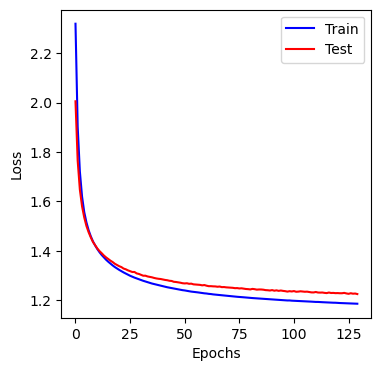

In [41]:
## Plot the training and test data losses
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.plot(history.history['loss'], 'b', label = 'Train')
ax.plot(history.history['val_loss'], 'r', label = 'Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

In [42]:

X_standardized = scaler.fit_transform(X)
X_reduced = PCA(n_components=2).fit_transform(X_standardized)

# Convert to a DataFrame
df = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
df['Label'] = y  # Add labels

# Create an interactive scatter plot
fig = px.scatter(df, x='PC1', y='PC2', color=df['Label'].astype(str),
                 title="PCA Visualization of Email Data",
                 labels={'color': 'Label'},
                 opacity=0.7)

fig.show()

In [43]:
# Reduce to 2D for static visualization
X_reduced_2d = PCA(n_components=2).fit_transform(X_standardized)

# Convert to a DataFrame
df_2d = pd.DataFrame(X_reduced_2d, columns=['PC1', 'PC2'])
df_2d['Label'] = y

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue=df_2d['Label'].astype(str), palette='viridis', data=df_2d, alpha=0.7)

# Customize plot
plt.title("2D PCA Visualization of Email Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Label")
plt.grid(True)

# Show the plot
plt.show()

In [44]:

### Step 2: Apply PCA ###
pca = PCA(n_components=50, random_state=42)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(X_standardized)

### Step 3: Apply t-SNE ###
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# Create DataFrame for visualization
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["Label"] = y

### Step 4: Plot using Plotly Express ###
fig = px.scatter(df_tsne, x="TSNE1", y="TSNE2", color=df_tsne["Label"].astype(str),
                 title="t-SNE Visualization of Email Data (Standardized + PCA Preprocessing)",
                 labels={"TSNE1": "t-SNE Component 1", "TSNE2": "t-SNE Component 2", "Label": "Email Category"},
                 opacity=0.7)

fig.show()

We observed that Word2Vec did not provide satisfactory separation or model results for our email categorization task. Upon further research, we discovered that Word2Vec generates word vectors in a way that does not always preserve the semantic meaning of words, especially in contexts where word order and deeper contextual understanding are crucial. This limitation likely contributed to the poor performance of our initial models.

To address this, we transitioned to using BERT (Bidirectional Encoder Representations from Transformers) for vectorizing the email text. Unlike Word2Vec, BERT captures the contextual meaning of words by considering the entire sentence structure, resulting in richer and more semantically meaningful embeddings. Additionally, BERT generates higher-dimensional vectors, which provide a more nuanced representation of the text. This shift allowed us to better capture the semantic relationships between words and phrases in the emails, ultimately improving the performance of our categorization models.

In [45]:
# Load the dataset
# Assuming you have a CSV file with "subject", "body", and "label" columns
df = pd.read_csv(os.path.join(datastore_path, "filtered_emails.csv"))  
print(df['X-Folder'].unique())

# Define mapping of folder names to numeric labels
folder_mapping = {
    "personal": 0,
    "hr": 1,
    "meetings and scheduling": 2,
    "operations and logistics": 3,
    "projects": 4,
    "corporate and legal": 5,
    "finance": 6,
    "archive and miscellaneous": 7,
    "it": 8
}

# Map X-Folder values to numeric labels
df = df[~df['X-Folder'].isin(['archive and miscellaneous', 'it'])]
df['label'] = df['X-Folder'].map(folder_mapping)

# Remove rows where X-Folder is not in the predefined list
df = df.dropna(subset=['label'])

# Count missing (NaN) subjects
empty_subject_count = df['Subject'].isna().sum()

# Count empty strings
empty_string_subject_count = (df['Subject'] == "").sum()

# Total empty subjects
total_empty_subjects = empty_subject_count + empty_string_subject_count

print(f"Total emails with empty subject: {total_empty_subjects}")

df = df[df['Subject'].notna() & (df['Subject'] != "")]

# Reset index after removal (optional)
df = df.reset_index(drop=True)

print(f"Remaining emails after removing empty subjects: {len(df)}")

['hr' 'personal' 'it' 'corporate and legal' 'archive and miscellaneous'
 'meetings and scheduling' 'finance' 'operations and logistics' 'projects']
Total emails with empty subject: 300
Remaining emails after removing empty subjects: 14081


We also decided to remove the folders Archive and Miscellaneous and IT from our analysis. Upon closer examination, we found that the emails in these folders were the most scattered and lacked a clear semantic focus. This scattering made it difficult to assign meaningful labels to these emails, and their inclusion would have introduced noise and ambiguity into our dataset. By removing these folders, we ensured that the remaining categories were more coherent and semantically distinct, which improved the quality of our dataset and the performance of our models.

In [46]:
# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply preprocessing to subject and body
df['subject_clean'] = df['Subject'].apply(preprocess_text)
df['body_clean'] = df['Body'].apply(preprocess_text)

# Load BERT model (SentenceTransformer for efficiency)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
subject_embeddings = bert_model.encode(df['subject_clean'].tolist(), show_progress_bar=True)
body_embeddings = bert_model.encode(df['body_clean'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/441 [00:00<?, ?it/s]

Batches:   0%|          | 0/441 [00:00<?, ?it/s]

In [1]:
# Convert labels to integer type
df['Number of Recipients'] = df['Number of Recipients'].astype(int)
df['Content-Length'] = df['Content-Length'].astype(int)

# Reshape numerical features to be 2D
num_recipients = df['Number of Recipients'].values.reshape(-1, 1)
content_length = df['Content-Length'].values.reshape(-1, 1)

# Combine both subject and body embeddings
X = np.hstack((subject_embeddings, body_embeddings, num_recipients, content_length))
y = df['label']  # Assuming labels are numerical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Define the logistic regression model
model = Sequential()
model.add(Dense(7, activation='softmax', input_dim=X_train.shape[1]))  # Logistic regression is a single-layer neural network

# Create an Adam optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.0001)  # Specify your learning rate here

# Compile the model
model.compile(optimizer=optimizer,  # Stochastic Gradient Descent
              loss='categorical_crossentropy',  # Log loss for binary classification
              metrics=['accuracy'])

# Define batch size and number of epochs
batch_size = 100  # Process 100 emails at a time
epochs = 130  # Train for 100 epochs

# Train the model with mini-batches
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test))

# Evaluate the model on the test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)  # Convert probabilities to class labels
y_test_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to integers
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

NameError: name 'df' is not defined

In [ ]:
## Plot the training and test data losses
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.plot(history.history['loss'], 'b', label = 'Train')
ax.plot(history.history['val_loss'], 'r', label = 'Test')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

In [ ]:
X_standardized = scaler.fit_transform(X)
X_reduced = PCA(n_components=2).fit_transform(X_standardized)

# Convert to a DataFrame
df = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
df['Label'] = y  # Add labels

# Create an interactive scatter plot
fig = px.scatter(df, x='PC1', y='PC2', color=df['Label'].astype(str),
                 title="PCA Visualization of Email Data",
                 labels={'color': 'Label'},
                 opacity=0.7)

fig.show()

In [ ]:
### Step 2: Apply PCA ###
pca = PCA(n_components=50, random_state=42)  # Reduce to 50 dimensions
X_pca = pca.fit_transform(X_standardized)

### Step 3: Apply t-SNE ###
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# Create DataFrame for visualization
df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["Label"] = y

### Step 4: Plot using Plotly Express ###
fig = px.scatter(df_tsne, x="TSNE1", y="TSNE2", color=df_tsne["Label"].astype(str),
                 title="t-SNE Visualization of Email Data (Standardized + PCA Preprocessing)",
                 labels={"TSNE1": "t-SNE Component 1", "TSNE2": "t-SNE Component 2", "Label": "Email Category"},
                 opacity=0.7)

fig.show()

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale your data (if necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')

# Step 4: Train the model
rf_model.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = rf_model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy:.4f}')

# Step 7: Optionally, check the class probabilities
y_pred_prob = rf_model.predict_proba(X_test)

In [ ]:
svm = LinearSVC(max_iter=10000, random_state=42, dual=False, tol=0.0001)
ova_classifier = OneVsRestClassifier(svm)

print("Starting model training...")
ova_classifier.fit(X_train, y_train)
print(f"Model training completed")

# Step 5: Make predictions
print("Making predictions on test set...")
y_pred = ova_classifier.predict(X_test)
print(f"Predictions shape: {y_pred.shape}")

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

In [ ]:
# RBF Kernel (Default)
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')  
svm_rbf.fit(X_train, y_train)

y_pred = svm_rbf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'RBF Kernel SVM Accuracy: {accuracy:.4f}')